In [1]:
import numpy as np
import copy as cp 
import random
from tqdm import tqdm_notebook as tqdm

### Define the Environment

The Stairwell: A stairwell connects the ground floor (G) of a palace with its first floor (F). It
consists of a total of n steps, indexed 1, 2, . . . , n, with step 1 close to G and step n connected to F. A robot may
start in any step and must learn to decide on whether it should go to F or to G. Both F and G are terminal states.
The robot gets a reward of 2 with probability 0.5, and 0 otherwise, when it descends from step i to i−1, 1 < i ≤ n.
It also gets a reward of 1 on going from step 1 to G. On the other hand, the robot pays a cost of 1 (reward −1)
when it moves from step i to i + 1, 1 ≤ i < n. Finally, the robot gets a bumper reward of 2n when it goes from
step n to F. The robot can only take one step at a time.

In [2]:
class Stairwell():
    def __init__(self,n):
        '''
        Initialize the Gridword
        self.state (list) : How many non-termimal state does this GridWordHave
        self.statePlus : Non terminal + terminal state
        self.posibleStateAction : Possible action for each state
        self.dynamic : Dynamics of this GridWorld
        '''
        self.n = n
        self.state = np.arange(1,n+1)
        self.statePlus = np.arange(1,n+2)
        self.posibleStateAction = self.defPossibleStateAction()
        self.dynamic = self.defineDynamic() 
        
    def defPossibleStateAction(self):
        #defining Possible action for this ServerProb
        posibleStateAction = dict()
        for s in self.state:
            posibleStateAction[s] = [1,2]  #Go_Up_stair, #Go_down_stair
        return posibleStateAction
    
    def defineDynamic(self):
        #defining the dynamics of the Environmvent
        dynamic = dict()
        for s in self.state:
            for a in self.posibleStateAction[s]:
                if a == 1: #when the agent has to go Up stair
                    dynamic[(s,a)] = [(s-1,1,1)]
                elif a == 2:
                    dynamic[(s,a)] = [(s+1,-1,1)]
        dynamic[(1,1)] = [(self.n+1,1,1)]
        dynamic[(self.n,2)] = [(self.n+1,2*self.n,1)]
        return dynamic

### Policy Iteration 

Below we have implemented below Algorithm:

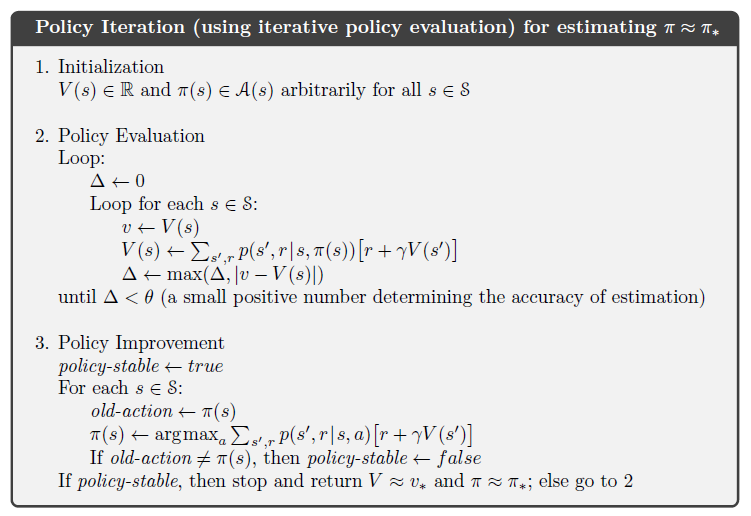

In [3]:
def policyEvaluation(policy,env,v,gamma = 1,threshold=0.0001):
    '''
    This method will evaluate the policy given to it i.e Step 2 of above pesudocode
    '''
    hist = []
    while True:
        delta = 0
        for s in env.state:
            vtemp = 0
            for action,sprob in policy[s]:
                for sDash,reward,prob in env.dynamic[(s,action)]:
                    vtemp += sprob * prob * (reward + gamma * v[sDash-1])
            delta = max(delta,abs(vtemp-v[s-1]))
            v[s-1] = vtemp
        #print(v,delta)
        hist.append(cp.deepcopy(v))
        if (delta < threshold):
            break;
    return hist

In [4]:
def oneStepLookAhead(s,env,v,gamma = 1):
    '''
    This method is use to do a one step lookahead.
    It is used when when we when we were imporivng the policy Step 3
    '''
    actionReward = []
    for action in env.posibleStateAction[s]:
        act = 0
        for sDash,reward,prob in env.dynamic[(s,action)]:
            act += prob * (reward + gamma * v[sDash-1])
        actionReward.append(act)
    return actionReward

In [5]:
def policyImprove(policy,env,v):
    '''
    This is a method to improve the policy according the values that have been calculated perviously
    '''
    stablePolicy = True
    newPolicy = dict()
    for s in env.state:
        prob = [j for _,j in policy[s]]
        #getting all the best action according to old policy.
        bestActionProb = max(prob)
        oldBestAction = set([act for act,proba in policy[s] if proba == bestActionProb])
        #get the values from each of values function
        actionRewards = oneStepLookAhead(s,env,v)
        #placing 1 which has the hightest values
        maxReward = [1 if i == max(actionRewards) else 0 for i in actionRewards ]
        #finding the probability
        maxReward = maxReward/np.sum(maxReward)
        #getting the best action to compare 
        newbestAction = set(np.argwhere(maxReward > 0).flatten()+1)
        #making the new Policy
        newPolicy[s] = [(i+1,j) for i,j in enumerate(maxReward) ]
        if(oldBestAction != newbestAction):
            #print(s,oldBestAction,newbestAction)
            stablePolicy = False
    return (stablePolicy,newPolicy)

In [6]:
def initilizeRandomPolicy(env):
    '''
    Initialze a equi-probabel policy.
    '''
    policy = dict()
    action = [1,2]
    prob = [0.5]*2
    for s in env.state:
        policy[s] = list(zip(action,prob))
    return policy

In [7]:
def printPolicy(policy):
    print("state \t [Up,\t      Down]")
    for key in policy:
        print(key ,"\t", policy[key])

In [8]:
env = Stairwell(2) 
v = np.zeros(len(env.statePlus))
policy = initilizeRandomPolicy(env)
history = dict()
policyDict = dict()
policyDict[0] = policy
i = 1
while True:
    hist = policyEvaluation(policy,env,v)
    history[i] = hist
    isStable,policy = policyImprove(policy,env,hist[-1])
    policyDict[i] = policy
    i+=1
    v = hist[-1]
    if isStable ==True:
        break;

In [9]:
history

{1: [array([0. , 2.5, 0. ]),
  array([1.25 , 3.125, 0.   ]),
  array([1.5625 , 3.28125, 0.     ]),
  array([1.640625 , 3.3203125, 0.       ]),
  array([1.66015625, 3.33007812, 0.        ]),
  array([1.66503906, 3.33251953, 0.        ]),
  array([1.66625977, 3.33312988, 0.        ]),
  array([1.66656494, 3.33328247, 0.        ]),
  array([3., 4., 0.])],
 2: [array([2.33332062, 4.        , 0.        ]),
  array([3., 4., 0.]),
  array([3., 4., 0.])],
 3: [array([3., 4., 0.])]}

In [33]:
policyDict

{0: {1: [(1, 0.5), (2, 0.5)],
  2: [(1, 0.5), (2, 0.5)],
  3: [(1, 0.5), (2, 0.5)],
  4: [(1, 0.5), (2, 0.5)],
  5: [(1, 0.5), (2, 0.5)],
  6: [(1, 0.5), (2, 0.5)],
  7: [(1, 0.5), (2, 0.5)],
  8: [(1, 0.5), (2, 0.5)],
  9: [(1, 0.5), (2, 0.5)],
  10: [(1, 0.5), (2, 0.5)]},
 1: {1: [(1, 0.0), (2, 1.0)],
  2: [(1, 0.0), (2, 1.0)],
  3: [(1, 0.0), (2, 1.0)],
  4: [(1, 0.0), (2, 1.0)],
  5: [(1, 0.0), (2, 1.0)],
  6: [(1, 0.0), (2, 1.0)],
  7: [(1, 0.0), (2, 1.0)],
  8: [(1, 0.0), (2, 1.0)],
  9: [(1, 0.0), (2, 1.0)],
  10: [(1, 0.0), (2, 1.0)]},
 2: {1: [(1, 0.0), (2, 1.0)],
  2: [(1, 0.5), (2, 0.5)],
  3: [(1, 0.5), (2, 0.5)],
  4: [(1, 0.5), (2, 0.5)],
  5: [(1, 0.5), (2, 0.5)],
  6: [(1, 0.5), (2, 0.5)],
  7: [(1, 0.5), (2, 0.5)],
  8: [(1, 0.5), (2, 0.5)],
  9: [(1, 0.5), (2, 0.5)],
  10: [(1, 0.5), (2, 0.5)]},
 3: {1: [(1, 0.0), (2, 1.0)],
  2: [(1, 0.5), (2, 0.5)],
  3: [(1, 0.5), (2, 0.5)],
  4: [(1, 0.5), (2, 0.5)],
  5: [(1, 0.5), (2, 0.5)],
  6: [(1, 0.5), (2, 0.5)],
  7: [(1, 

In [59]:
env.dynamic

{(1, 1): [(3, 1, 1)],
 (1, 2): [(2, -1, 1)],
 (2, 1): [(1, 1, 1)],
 (2, 2): [(3, 4, 1)]}